### Importações necessárias

In [134]:
import unidecode
import re
import string
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix

from gensim.models import Word2Vec

#### Análise de dataset

In [2]:
df = pd.read_csv("Dataset_final.csv")

df.head()

,texts,labels
0,Como cometer suicídio sem dx a mãe triste,0
1,Estou nova demais p cometer esse suicídio,0
2,"""Nunca dirijo meu carro por cima de uma ponte ...",0
3,Nem imagino como seria minha vida sem esse gat...,0
4,A vida tá me testando para ver qual vou comet...,0


In [3]:
df.describe()

,labels
count,1063.000000
mean,0.503293
std,0.500225
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 2 columns):
texts     1063 non-null object
labels    1063 non-null int64
dtypes: int64(1), object(1)
memory usage: 16.7+ KB


#### Limpeza de dados

In [63]:
stopwords = nltk.corpus.stopwords.words('portuguese')
stemmer = nltk.stem.RSLPStemmer()

def clean_text(text):
    
    # Normalize to Lower
    text = text.lower()
    
    # Remove Accent
    text = unidecode.unidecode(text)
    
    # Split ponctuation
    text = ' '.join(re.findall(r"[\w]+|[" + string.punctuation + r"]",text))
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove Stopwords
#     text = ' '.join([word for word in text.split() if word not in stopwords])
    
    return text.strip()

In [6]:
new_df = df

new_df['texts'] = new_df['texts'].apply(clean_text)
new_df['lenght'] = new_df['texts'].str.split().str.len()

new_df = new_df.drop_duplicates()

In [7]:
new_df.describe()

,labels,lenght
count,1031.000000,1031.000000
mean,0.516004,10.636275
std,0.499986,6.765174
min,0.000000,2.000000
25%,0.000000,6.000000
50%,1.000000,9.000000
75%,1.000000,13.000000
max,1.000000,57.000000


In [8]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031 entries, 0 to 1062
Data columns (total 3 columns):
texts     1031 non-null object
labels    1031 non-null int64
lenght    1031 non-null int64
dtypes: int64(2), object(1)
memory usage: 32.2+ KB


In [9]:
texts = new_df['texts']
labels = new_df['labels']

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(texts, labels, test_size=0.33, random_state=42)

#### Treinamento

In [146]:
wv_texts = [text.split() for text in new_df['texts']]
vocab = ' '.join(new_df['texts']).split()

embedding_size = 50
model = Word2Vec(size=embedding_size, window=3, min_count=1, workers=4, sg=0)
model.build_vocab(wv_texts, progress_per=10000)


model.train(wv_texts, total_examples=model.corpus_count, epochs=30)

(214969, 328980)

In [99]:
model.wv.most_similar(positive=["morrer"])

[('so', 0.997465968132019),
 ('quero', 0.9970492124557495),
 ('deitar', 0.9957489967346191),
 ('deus', 0.9955381155014038),
 ('ultimamente', 0.9951074123382568),
 ('chorar', 0.9948307275772095),
 ('posso', 0.9947211742401123),
 ('sera', 0.9945458173751831),
 ('eu', 0.9944360852241516),
 ('q', 0.9943845272064209)]

In [100]:
model.wv.most_similar(positive=["desisto"])

[('tudo', 0.9938195943832397),
 ('juro', 0.9905190467834473),
 ('serio', 0.990053117275238),
 ('amorosa', 0.9895961880683899),
 ('namoral', 0.9887123107910156),
 ('olha', 0.9885029792785645),
 ('de', 0.9884490966796875),
 ('ai', 0.9882113933563232),
 ('especie', 0.9880273342132568),
 ('humana', 0.9877334833145142)]

In [101]:
model.wv.most_similar(positive=["cansei"])

[('solteira', 0.991449773311615),
 ('de', 0.9911640882492065),
 ('serio', 0.9903638958930969),
 ('dormi', 0.9885148406028748),
 ('gente', 0.9881535172462463),
 ('sofrida', 0.9879635572433472),
 ('desanimo', 0.9878731966018677),
 ('estudante', 0.9877848029136658),
 ('td', 0.9875407218933105),
 ('affs', 0.9873358011245728)]

In [102]:
index2word = model.wv.index2word

def avg_feat_vector(sentece):
    words = sentece.split()
    feat_vec = np.zeros((embedding_size, ), dtype="float")
    n_words = 0
    
    for word in words:
        if word in index2word:
            n_words += 1
            feat_vec = np.add(feat_vec, model.wv.__getitem__(word))
    if (n_words > 0):
        feat_vec = np.divide(feat_vec, n_words)
    
    return feat_vec

In [149]:
def gs_result(X_train, Y_train, X_test, Y_test):
    parameters = {'C':[1,10,100,1000], 
                  'gamma':[1,0.1,0.001,0.0001],
                 'kernel':['rbf', 'linear']}

    svc = svm.SVC(kernel='rbf', probability=True)
    
    clf = GridSearchCV(svc, parameters, cv=10, iid=True)
    clf = clf.fit(X_train, Y_train)
    
    y_pred = clf.predict(X_test)
    
    print(f"Melhores parâmetros: {clf.best_params_}")
    print(f"Melhor score: {clf.best_score_:.2f}%")
    print()
    print(f'Acurácia : {accuracy_score(Y_test,y_pred):.2f}%')
    print(f'Precisão : {precision_score(Y_test,y_pred):.2f}%')
    print(f'Revocação : {recall_score(Y_test,y_pred):.2f}%')
    print(f'F1 : {f1_score(Y_test,y_pred):.2f}%')
    print()
    
    df_cm = pd.DataFrame(confusion_matrix(Y_test,y_pred), index = [i for i in ["Depressiva", "Outras"]],
                  columns = [i for i in ["Depressiva", "Outras"]])
    plt.figure(figsize = (4,3))
    sn.heatmap(df_cm, annot=True,  cmap="YlGnBu")
    
    return clf

=== SVM - TF-IDF com GridSearch ===

Melhores parâmetros: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Melhor score: 0.82%

Acurácia : 0.86%
Precisão : 0.85%
Revocação : 0.86%
F1 : 0.86%



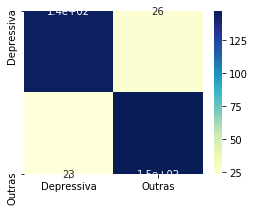

In [150]:
vectorizer = CountVectorizer()

print("=== SVM - TF-IDF com GridSearch ===\n")

train_data_tfidf = vectorizer.fit_transform(X_train)
test_data_tfidf = vectorizer.transform(X_test)

clf_tfidf = gs_result(train_data_tfidf, Y_train, test_data_tfidf, Y_test)

=== SVM - Word2Vec com GridSearch ===

Melhores parâmetros: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Melhor score: 0.79%

Acurácia : 0.80%
Precisão : 0.76%
Revocação : 0.89%
F1 : 0.82%



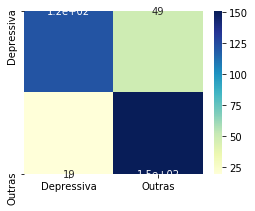

In [151]:
print("=== SVM - Word2Vec com GridSearch ===\n")

train_data_w2v = list(X_train.apply(avg_feat_vector))
test_data_w2v = list(X_test.apply(avg_feat_vector))

clf_w2v  = gs_result(train_data_w2v, Y_train, test_data_w2v, Y_test)

In [148]:
sentece = "Hoje o dia ta lindo para um suicidio"
sentece = clean_text(sentece)

prob_tfidf = clf.predict_proba(vectorizer.transform([sentece]).todense())
prob_w2v = clf_w2v.best_estimator_.predict_proba([list(avg_feat_vector(sentece))])

In [145]:
print(prob_tfidf, prob_w2v)

[[0.94421669 0.05578331]] [[0.52657178 0.47342822]]
